# Two Axion System Dynamics

In [1]:
import matplotlib.pyplot as plt, numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.fft import rfft, rfftfreq, irfft

$$
V = \sum_i \Lambda_i^4 \left( 1 - \cos(Q_{i,j} \theta_j) \right)
$$

$$
\frac{\partial V}{\partial \phi_k} = \frac{ \partial V } { \partial f_k \theta_k } = \sum_i \frac{\Lambda_i^4}{f_k} Q_{i,k} \sin(Q_{i,j} \theta_j)
$$

$$
\ddot{\theta}_k + 3 H \dot{\theta}_k + \frac{1}{f_k^2} \frac{ \partial V } { \partial \theta_k } = 0
$$

$$
\rho = \frac{1}{2} \sum_k (f_k \dot{\theta}_k)^2 + V(\{\theta_k\})
$$

$$
\ddot{\theta}_k + 3 H \dot{\theta}_k + \sum_i \frac{\Lambda_i^4}{f_k^2} Q_{i,k} \sin(Q_{i,j} \theta_j) = 0
$$

$$
\mathbf{\Theta} = \left[ \theta_1 \, \theta_2 \right]
$$

$$
\ddot{\mathbf{\Theta}} + 3 H \dot{\mathbf{\Theta}} + \mathbf{M} \sin(\mathbf{Q} \mathbf{\Theta}) = 0
$$

$$
[\mathbf{M}]_{k, i} := \frac{\Lambda_i^4}{f_k^2} Q_{i, k}
$$

In [17]:
flip_t_and_H = lambda x: 1 / (2*x)

def rhs(t, y, M, Q):
    H = flip_t_and_H(t)
    N = y.size // 2
    thetas, theta_dots = y[:N], y[N:]
    force = M @ np.sin(Q @ thetas)
    theta_dotdots = - 3.0 * H * theta_dots - force
    return np.hstack([theta_dots, theta_dotdots])

def calc_V(thetas, Lambda, Q): 
    return np.dot(Lambda**4, 1 - np.cos(Q @ thetas))

def calc_energy(y, f, Lambda, Q):
    N = y.size // 2
    thetas, theta_dots = y[:N], y[N:]
    return 0.5 * np.sum((f * theta_dots)**2) + calc_V(thetas, Lambda, Q)

def calc_t_interval(H0, tspan): 
    start = flip_t_and_H(H0)
    return start, start + tspan

def calc_M(f, Lambda, Q):
    return Q.T * (1 / f[:, None]**2) * Lambda[None, :]**4
    
def solve(H0, tspan, theta0s, f, Lambda, Q):
    M = calc_M(f, Lambda, Q)
    init = np.hstack([theta0s, np.zeros(Q.shape[0])])
    sol = solve_ivp(rhs, calc_t_interval(H0, tspan), init, args=(M, Q), 
                    method="BDF", rtol=1e-10, dense_output=True)
    assert sol.success
    return sol

names  = [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta}_1$", r"$\dot{\theta}_2$"]

In [3]:
theta0s = np.array([-2.5, np.pi - 1e-3])
f = np.array([1, 100])
Lambda = np.array([1, 2])
Q = np.array([[1,1], [1, 0]])
H0 = 10
time = 1e4
sol = solve(H0, time, theta0s, f, Lambda, Q)

Text(0, 0.5, 'field value')

/tmp/ipykernel_30389/2317895137.py:1: RuntimeWarning: divide by zero encountered in true_divide
  flip_t_and_H = lambda x: 1 / (2*x)


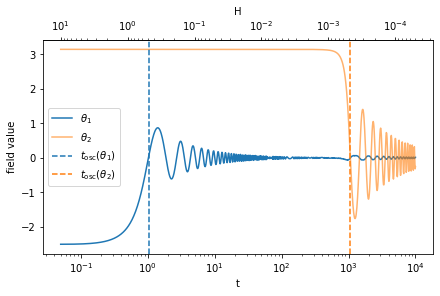

In [19]:
ts = np.geomspace(sol.t[1], sol.t[-1], 1000)
theta1, theta2, theta2_dot, theta1_dot = u = sol.sol(ts)
plt.subplots(constrained_layout=True)
plt.semilogx(ts, theta1, label=names[0])
plt.semilogx(ts, theta2, alpha=0.6, label=names[1])
#plt.xlim(1e1, ts[-1])
first_sign_change = lambda xs: np.where(np.sign(xs) != np.sign(xs[0]))[0][0]
i1 = first_sign_change(theta1)
i2 = first_sign_change(theta2)
t_osc_1 = ts[i1]
t_osc_2 = ts[i2]
plt.axvline(t_osc_1, color="tab:blue", ls="--", label=r"$t_\mathrm{osc}(\theta_1)$")
plt.axvline(t_osc_2, color="tab:orange", ls="--", label=r"$t_\mathrm{osc}(\theta_2)$")

sec_H_ax = plt.gca().secondary_xaxis("top", functions=(flip_t_and_H, flip_t_and_H))
sec_H_ax.set_xlabel("H")

plt.legend()
plt.xlabel("t")
plt.ylabel("field value")

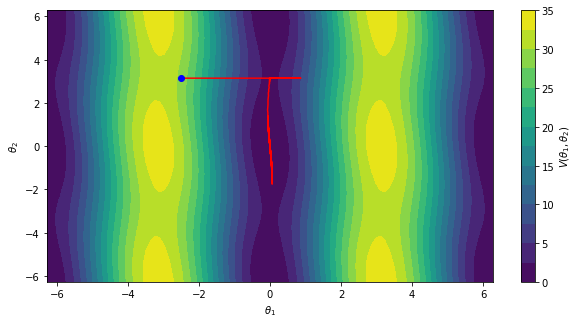

In [5]:
interval=np.pi*2
def calc_range(x):
    return np.linspace(np.floor(np.min(x) / interval) * interval, np.ceil(np.max(x) / interval) * interval, 100)
xs, ys = calc_range(theta1), calc_range(theta2)
V = np.array([[calc_V((x, y), Lambda, Q) for x in xs] for y in ys])

plt.figure(figsize=(10,5))
plt.contourf(xs, ys, V, levels=15)
plt.plot(theta1, theta2, color="r")
plt.plot([theta1[0]], [theta2[0]], "bo")
plt.xlabel(names[0])
plt.ylabel(names[1])
plt.colorbar(label=r"$V(\theta_1, \theta_2)$")

Text(0, 0.5, 'energy density')

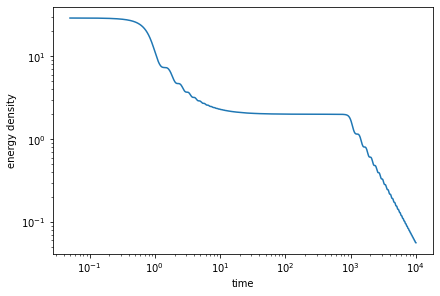

In [6]:
fig, ax = plt.subplots(constrained_layout=True)
rho = np.array([ calc_energy(x, f, Lambda, Q) for x in u.T ])
ax.loglog(ts, rho)
ax.set_xlabel("time")
ax.set_ylabel("energy density")

$$
\rho \sim a^{-3} \sim (t^{0.5})^{-3} = t^{-1.5}
$$
$$
\theta \sim \rho^{0.5} \sim t^{-0.75}
$$

Text(0.5, 1.0, '2')

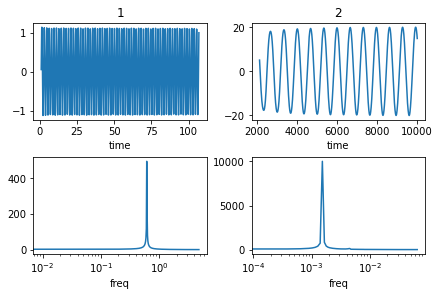

In [8]:
n = 1 << 10
ts_1 = np.linspace(t_osc_1, t_osc_2 / 10, n)
ts_2 = np.linspace(t_osc_2 * 2, sol.t[-1], n)
dt_1 = ts_1[1] - ts_1[0]
dt_2 = ts_2[1] - ts_2[0]
signal_1 = sol.sol(ts_1)[0, :] * ts_1**0.75
signal_2 = sol.sol(ts_2)[0, :] * ts_2**0.75
fft1 = rfft(signal_1)
fft2 = rfft(signal_2)
freq1 = rfftfreq(len(signal_1), dt_1)
freq2 = rfftfreq(len(signal_2), dt_2)
fig, axs = plt.subplots(2,2, constrained_layout=True)
axs[0, 0].plot(ts_1, signal_1)
axs[0, 1].plot(ts_2, signal_2)
axs[1, 0].semilogx(freq1, np.abs(fft1))
axs[1, 1].semilogx(freq2, np.abs(fft2))
axs[0, 0].set_xlabel("time")
axs[0, 1].set_xlabel("time")
axs[1, 0].set_xlabel("freq")
axs[1, 1].set_xlabel("freq")
axs[0, 0].set_title("1")
axs[0, 1].set_title("2")

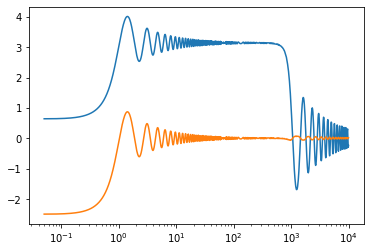

In [15]:
plt.semilogx(ts, Q[0,0]*theta1 + Q[0,1]*theta2)
plt.semilogx(ts, Q[1,0]*theta1 + Q[1,1]*theta2)

array([[1, 1],
       [1, 0]])